In [41]:
!pip install -q -U keras-tuner
import keras_tuner as kt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import PIL
import os
import glob
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [39]:
def load_dataset(path):
    """loads a dataset given a path"""
    label_key = {'center':0,
             'down':1,
             'left':2,
             'right':3,
             'up':4}
    X = []
    y = []
    for class_name in label_key.keys():
        class_path = os.path.join(path, class_name)
        files = glob.glob(os.path.join(class_path,'*.jpg'))
        for f in files:
            image = np.asarray(PIL.Image.open(f))
            image = np.expand_dims(image, axis=0)
            X.append(image)
            y.append(label_key[class_name])
    return np.concatenate(X), np.array(y)

def plot_confusion_matrix(ytrue, ypred, title, path):
    """plots and saves a confusion matrix and 
    prints a classification report"""
    confusion_arr = confusion_matrix(ytrue, ypred)

    df_cm = pd.DataFrame(confusion_arr, 
      index = ['center', 'down', 'left', 'right', 'up'],
      columns = ['center', 'down', 'left', 'right', 'up'])

    fig = plt.figure(figsize=(10,10))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    res = sns.heatmap(df_cm, annot=True, vmin=0.0, vmax=100.0, fmt='1d', cmap=cmap, cbar=False)
    res.invert_yaxis()
    plt.title(title)
    filename = '_'.join(title.lower().split())
    savepath = os.path.join(path, f'{filename}.png')
    plt.savefig(f'{filename}.png', dpi=100, bbox_inches='tight')
    plt.show()
    plt.close()
    report = classification_report(ytrue, ypred)
    print(report)


In [11]:
def build_cnn(height:int=35, width:int=63):
    
    input_layer = tf.keras.Input(shape=(height, width, 1))
    # normalize pixel values
    normalized_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(height, width, 1))(input_layer)
    # block one
    block_one = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu')(normalized_input)
    block_one = tf.keras.layers.MaxPooling2D((2, 2))(block_one)
    # block two
    block_two = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(block_one)
    block_two = tf.keras.layers.MaxPooling2D((2, 2))(block_two)
    block_two = tf.keras.layers.Dropout(0.5)(block_two)
    # block three
    block_three = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(block_two)
    block_three = tf.keras.layers.MaxPooling2D((2, 2))(block_three)
    block_three = tf.keras.layers.Dropout(0.6)(block_three)
    # flattening
    flattened = tf.keras.layers.Flatten()(block_three)
    # dense layer
    dense_layer = tf.keras.layers.Dense(128, activation='relu')(flattened)
    # output layer
    output_layer = tf.keras.layers.Dense(5, activation='softmax')(dense_layer)
    
    # build model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [6]:
# load processed data for train/dev sets
X_train, y_train = load_dataset('../data/train/')
X_dev, y_dev = load_dataset('../data/dev/')

In [23]:
# build model
def hypermodel_builder(hp, height:int=35, width:int=63):
    """hypermodel wrapper for a tensorflow model, to be used with 
    keras tuner"""
    input_layer = tf.keras.Input(shape=(height, width, 1))
    # normalize pixel values
    normalized_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(height, width, 1))(input_layer)
    # block one
    block_one = tf.keras.layers.Conv2D(filters=16,
                                       kernel_size=(3,3), 
                                       strides=(1, 1), 
                                       padding='same', 
                                       activation='relu')(normalized_input)
    block_one = tf.keras.layers.MaxPooling2D((2, 2))(block_one)
    # block two
    block_two = tf.keras.layers.Conv2D(filters=32,
                                       kernel_size=(3,3), 
                                       strides=(1, 1), 
                                       padding='same', 
                                       activation='relu')(block_one)
    block_two = tf.keras.layers.MaxPooling2D((2, 2))(block_two)
    block_two = tf.keras.layers.Dropout(0.5)(block_two)
    # block three
    block_three = tf.keras.layers.Conv2D(filters=64,
                                       kernel_size=(3,3), 
                                       strides=(1, 1), 
                                       padding='same', 
                                       activation='relu')(block_two)
    block_three = tf.keras.layers.MaxPooling2D((2, 2))(block_three)
    block_three = tf.keras.layers.Dropout(0.6)(block_three)
    # flattening
    flattened = tf.keras.layers.Flatten()(block_three)
    # dense layer
    dense_layer = tf.keras.layers.Dense(128, activation='relu')(flattened)
    # output layer
    hp_dense_units = hp.Int('units', min_value=32, max_value=256, step=32)
    output_layer = tf.keras.layers.Dense(units=hp_dense_units, activation='softmax')(dense_layer)
    
    # build model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
    return model

In [26]:
# hyperparameter tuner
tuner = kt.RandomSearch(
    hypermodel_builder,
    objective='val_loss',
    max_trials=5,
    seed=31,
    hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True,
)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [27]:
# run hyperparameter search using early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train, y_train, epochs=10, validation_split=0.2, callbacks=[early_stopping])

Trial 1 Complete [00h 02m 11s]
val_loss: 10.56649398803711

Best val_loss So Far: 10.066262245178223
Total elapsed time: 00h 02m 11s
INFO:tensorflow:Oracle triggered exit


In [19]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the last densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the last densely-connected
layer is 192 and the optimal learning rate for the optimizer
is 0.0001.



In [28]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

mc = tf.keras.callbacks.ModelCheckpoint('./models/tuned_cnn.h5', monitor='val_accuracy', 
                                        mode='max', verbose=1, save_best_only=True)

callbacks = [es,mc]

history = model.fit(x=X_train, y=y_train, 
                    validation_data=(X_dev, y_dev),
                    batch_size=32, epochs=100, callbacks=callbacks)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/100
719/719 [==============================] - 20s 27ms/step - loss: 1.0520 - accuracy: 0.6326 - val_loss: 0.3434 - val_accuracy: 0.9067

Epoch 00001: val_accuracy improved from -inf to 0.90672, saving model to ./models/tuned_cnn.h5
Epoch 2/100
719/719 [==============================] - 20s 28ms/step - loss: 0.3589 - accuracy: 0.8967 - val_loss: 0.2812 - val_accuracy: 0.9212

Epoch 00002: val_accuracy improved from 0.90672 to 0.92116, saving model to ./models/tuned_cnn.h5
Epoch 3/100
719/719 [==============================] - 21s 29ms/step - loss: 0.3023 - accuracy: 0.9118 - val_loss: 0.2435 - val_accuracy: 0.9267

Epoch 00003: val_accuracy improved from 0.92116 to 0.92673, saving model to ./models/tuned_cnn.h5
Epoch 4/100
719/719 [==============================] - 21s 29ms/step - loss: 0.2634 - accuracy: 0.9207 - val_loss: 0.2129 - val_accuracy: 0.9361

Epoch 00004: val_accuracy improved from 0.92673 to 0.93613, saving model to ./models/tuned_cnn.h5
Epoch 5/100
719/719 [======

In [32]:
tuned_cnn =tf.keras.models.load_model('./models/tuned_cnn.h5')
ypred = tuned_cnn.predict(X_dev)
ypred = [np.argmax(pred_vec) for pred_vec in ypred]

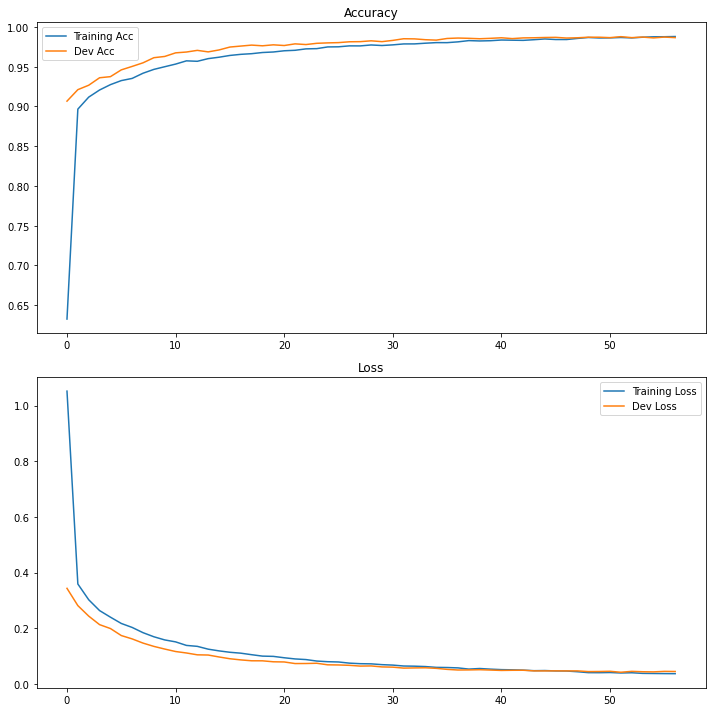

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

fig, axs = plt.subplots(2, 1, figsize=(10,10))

axs[0].plot(acc, label='Training Acc')
axs[0].plot(val_acc, label='Dev Acc')
axs[0].set_title('Accuracy')
axs[0].legend()

axs[1].plot(loss, label='Training Loss')
axs[1].plot(val_loss, label='Dev Loss')
axs[1].set_title('Loss')
axs[1].legend()

plt.savefig('./plots/tuned_cnn_training.png')

fig.tight_layout() 

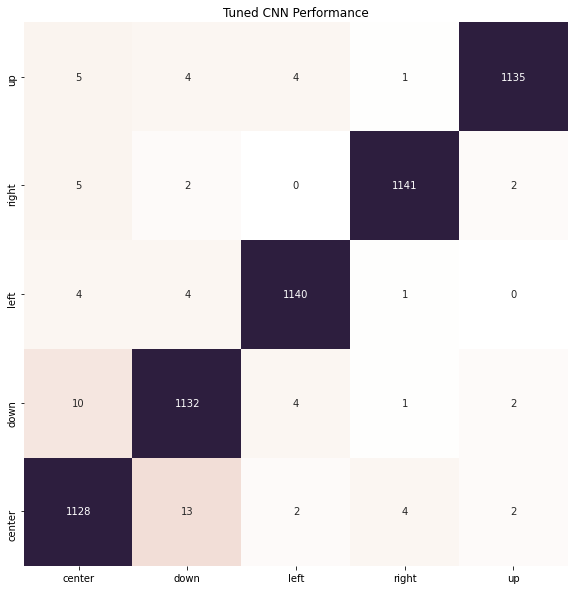

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1149
           1       0.98      0.99      0.98      1149
           2       0.99      0.99      0.99      1149
           3       0.99      0.99      0.99      1150
           4       0.99      0.99      0.99      1149

    accuracy                           0.99      5746
   macro avg       0.99      0.99      0.99      5746
weighted avg       0.99      0.99      0.99      5746



In [42]:
plot_confusion_matrix(y_dev, ypred, 'Tuned CNN Performance', './plots/')